In [16]:
import pandas as pd
import numpy as np
train = pd.read_excel('training_data.xlsx')
pd.set_option('display.max_columns',None)
train

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,relation,target
0,1,1,1,1,0,0,0,1,0,0,43,1,5,0,0,38,0,1,0
1,0,0,0,0,0,0,1,1,0,1,28,0,0,0,0,43,0,4,0
2,1,0,1,1,1,1,1,1,1,1,37,0,9,0,1,63,0,4,1
3,1,1,0,1,1,0,0,1,1,1,32,0,1,0,0,15,0,4,1
4,0,1,0,0,1,1,0,0,1,1,52,1,5,0,0,31,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,1,1,1,1,1,1,1,0,1,1,59,1,9,0,0,64,0,4,1
816,1,1,1,1,1,0,1,1,1,1,43,1,9,0,0,42,0,4,1
817,1,0,1,1,0,1,1,1,0,1,20,0,4,0,0,14,0,4,1
818,1,0,1,1,1,0,0,1,1,0,25,0,8,0,0,33,0,4,1


In [17]:
X_train = train.drop('target',axis=1)
y_train = train.target

In [18]:
test = pd.read_excel('testing_data.xlsx')
X_test = test.drop('target',axis=1)
y_test = test.target

Grid Search CV for Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [20]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
param_grid = []

# l2 penalty supports many solvers
param_grid.append({
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg']
})

# l1 penalty only supported by liblinear and saga
param_grid.append({
    'penalty': ['l1'],
   
    'solver': ['liblinear', 'saga']
})

# Combine param grids into one
model_params_lr = {
    'logistic_regression': {
        'model': LogisticRegression(max_iter=3000),
        'params': param_grid
    }
}

In [22]:
# Grid Search with Stratified K-Fold
scores_lr = []
CV_lr = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

for model_name, mp in model_params_lr.items():
    clf_lr = GridSearchCV(mp['model'], mp['params'], cv=CV_lr, scoring='accuracy', return_train_score=False)
    clf_lr.fit(X_train_scaled, y_train)
    scores_lr.append({
        'model': model_name,
        'best_score': clf_lr.best_score_,
        'best_params': clf_lr.best_params_
    })

In [23]:
# 4. Convert results to DataFrame
df_lr = pd.DataFrame(scores_lr, columns=['model', 'best_score', 'best_params'])
pd.set_option('display.max_colwidth', None)
print(df_lr)

                 model  best_score                               best_params
0  logistic_regression    0.923171  {'penalty': 'l2', 'solver': 'liblinear'}


In [24]:
model_lr = clf_lr.best_estimator_
model_lr.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=3000, solver='liblinear')

In [25]:
model_lr.score(X_test_scaled,y_test)

0.9290780141843972

In [26]:
# Predictions and evaluation
y_pred_lr = model_lr.predict(X_test_scaled)

print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_lr))


Classification Report on Test Set:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       105
           1       0.78      1.00      0.88        36

    accuracy                           0.93       141
   macro avg       0.89      0.95      0.91       141
weighted avg       0.94      0.93      0.93       141



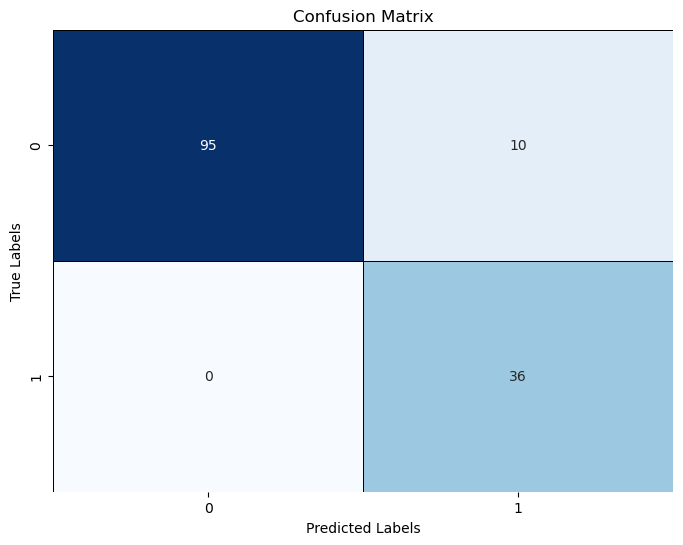

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))  # Make figure larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (usually class 1)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]


In [29]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba_lr)

print(f'AUC score: {auc_score:.4f}')


AUC score: 1.0000


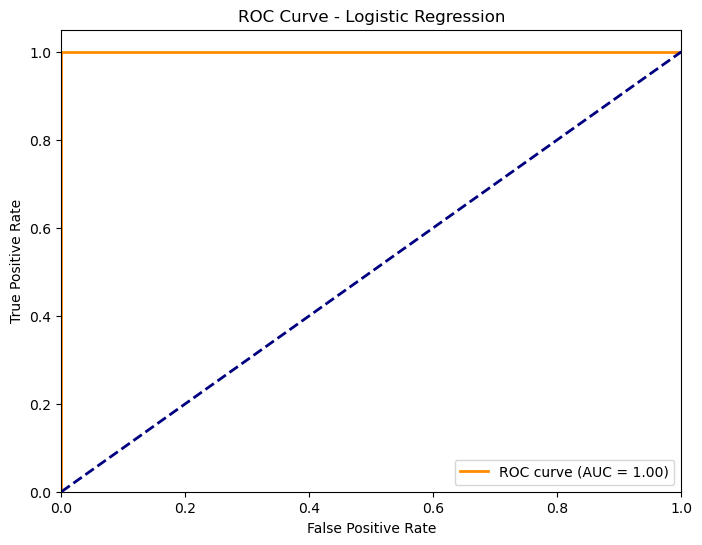

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Grid Search CV for Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [17]:
model_params_dt = {
    'Decision_tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 'log2'],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': [0.0, 0.001, 0.01]
        }
    }
}

In [18]:
# Grid Search with Stratified K-Fold
scores_dt = []
CV_dt = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

for model_name, mp in model_params_dt.items():
    clf_dt = GridSearchCV(mp['model'], mp['params'], cv=CV_dt, scoring='accuracy', return_train_score=False)
    clf_dt.fit(X_train_scaled, y_train)
    scores_dt.append({
        'model': model_name,
        'best_score': clf_dt.best_score_,
        'best_params': clf_dt.best_params_
    })

In [19]:
df_dt = pd.DataFrame(scores_dt,columns=['model','best_score','best_params'])
pd.set_option('display.max_colwidth', None)
df_dt

,model,best_score,best_params
0,Decision_tree,0.89878,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}"


In [20]:
model_dt = clf_dt.best_estimator_
model_dt.fit(X_train_scaled,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [21]:
model_dt.score(X_test_scaled,y_test)

0.8156028368794326

In [22]:
# Predictions and evaluation
y_pred_dt = model_dt.predict(X_test_scaled)

print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_dt))


Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       105
           1       0.60      0.83      0.70        36

    accuracy                           0.82       141
   macro avg       0.77      0.82      0.78       141
weighted avg       0.85      0.82      0.82       141



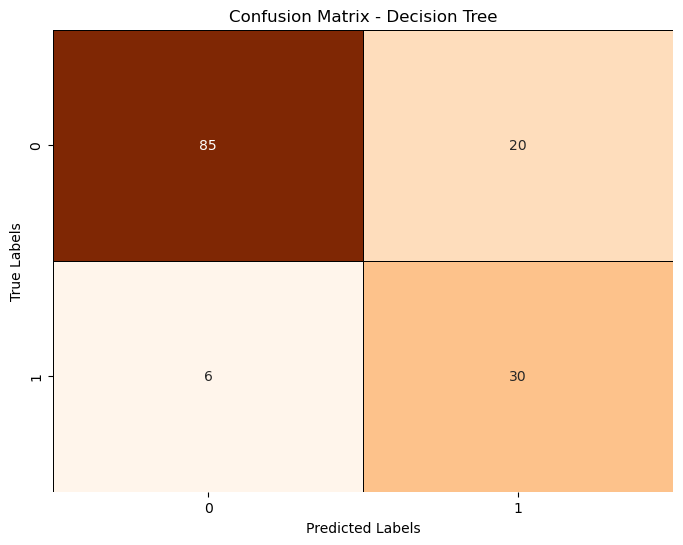

In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Increase figure size to make it more readable
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

AUC score (Decision Tree): 0.8566


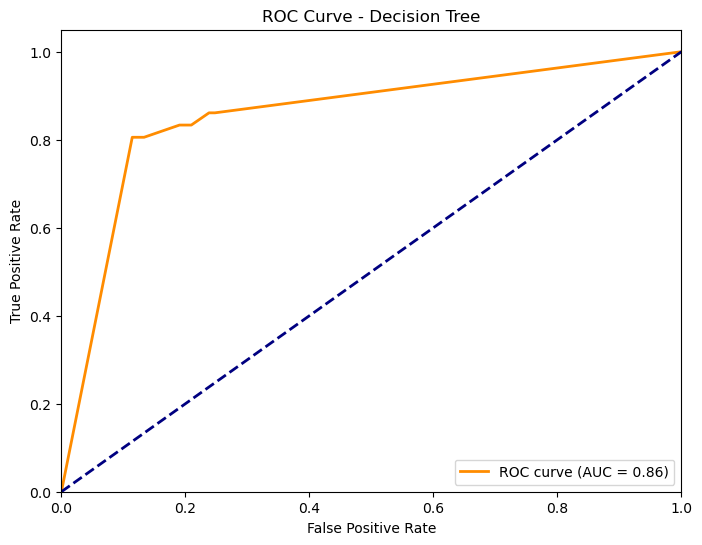

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (usually class 1)
y_pred_proba_dt = model_dt.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

# Compute AUC
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f'AUC score (Decision Tree): {auc_dt:.4f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()


Support Vector Machine - SVM

In [32]:
from sklearn.svm import SVC

In [33]:
model_params_svc = {
    'svm':{
        'model':SVC(),
        'params':{
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1] 
        }
    }
}

In [9]:
# Grid Search with Stratified K-Fold
scores_svc = []
CV_svc = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

for model_name, mp in model_params_svc.items():
    clf_svc = GridSearchCV(mp['model'], mp['params'], cv=CV_svc, scoring='accuracy', return_train_score=False)
    clf_svc.fit(X_train_scaled, y_train)
    scores_svc.append({
        'model': model_name,
        'best_score': clf_svc.best_score_,
        'best_params': clf_svc .best_params_
    })

In [34]:
df_svc = pd.DataFrame(scores_svc,columns=['model','best_score','best_params'])
pd.set_option('display.max_colwidth', None)
df_svc

,model,best_score,best_params
0,svm,0.932927,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"


In [35]:
model_svc = clf_svc.best_estimator_
model_svc.fit(X_train_scaled,y_train)

SVC(C=10, gamma=0.1)

In [36]:
model_svc.score(X_test_scaled,y_test)

0.9290780141843972

In [37]:
# Predictions and evaluation
y_pred_svc = model_svc.predict(X_test_scaled)

print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_svc))


Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       105
           1       0.80      0.97      0.88        36

    accuracy                           0.93       141
   macro avg       0.89      0.94      0.91       141
weighted avg       0.94      0.93      0.93       141



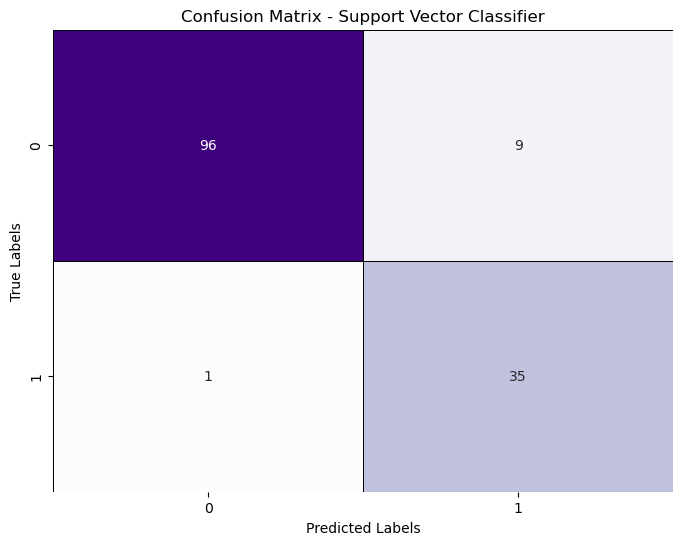

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Bigger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix - Support Vector Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

AUC score (SVM): 0.9794


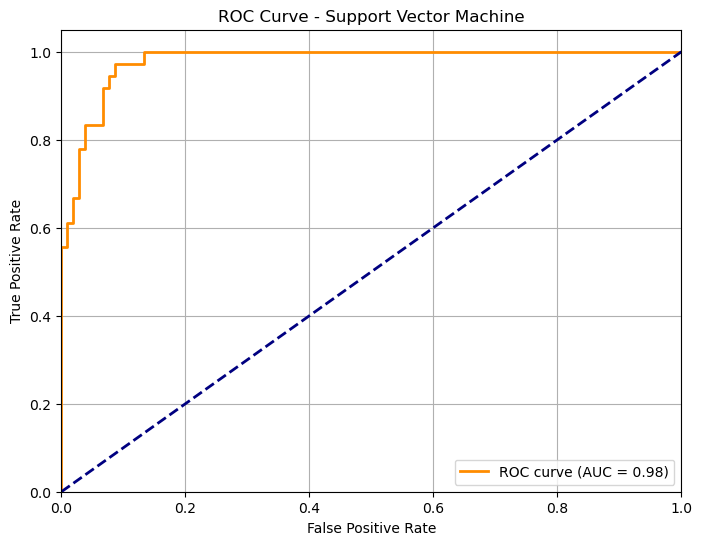

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get decision function scores for the test set
y_pred_scores_svc = model_svc.decision_function(X_test_scaled)

# Compute ROC curve
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_scores_svc)

# Compute AUC
auc_svc = roc_auc_score(y_test, y_pred_scores_svc)

print(f'AUC score (SVM): {auc_svc:.4f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal for random guess

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
model_params_rfc = {
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200,500,1000],
            'criterion': ['gini', 'entropy', 'log_loss'],
             'max_depth':[None,20,50,100]

        }
    }
}

In [42]:
scores_rfc = []
CV_rfc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, mp in model_params_rfc.items():
    clf_rfc = GridSearchCV(
        mp['model'],
        mp['params'],
        cv=CV_rfc,
        scoring='accuracy',
        return_train_score=False
    )
    clf_rfc.fit(X_train_scaled, y_train)
    scores_rfc.append({
        'model': model_name,
        'best_score': clf_rfc.best_score_,
        'best_params': clf_rfc.best_params_
    })

In [43]:
df_rfc = pd.DataFrame(scores_rfc, columns=['model', 'best_score', 'best_params'])
pd.set_option('display.max_colwidth', None)
print(df_rfc)

           model  best_score  \
0  random_forest    0.943902   

                                                     best_params  
0  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}  


In [44]:
model_rfc = clf_rfc.best_estimator_
model_rfc.fit(X_train_scaled,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [45]:
model_rfc.score(X_test_scaled,y_test)

0.950354609929078

In [46]:
# Predictions and evaluation
y_pred_rfc = model_rfc.predict(X_test_scaled)

print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_rfc))


Classification Report on Test Set:

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       105
           1       0.84      1.00      0.91        36

    accuracy                           0.95       141
   macro avg       0.92      0.97      0.94       141
weighted avg       0.96      0.95      0.95       141



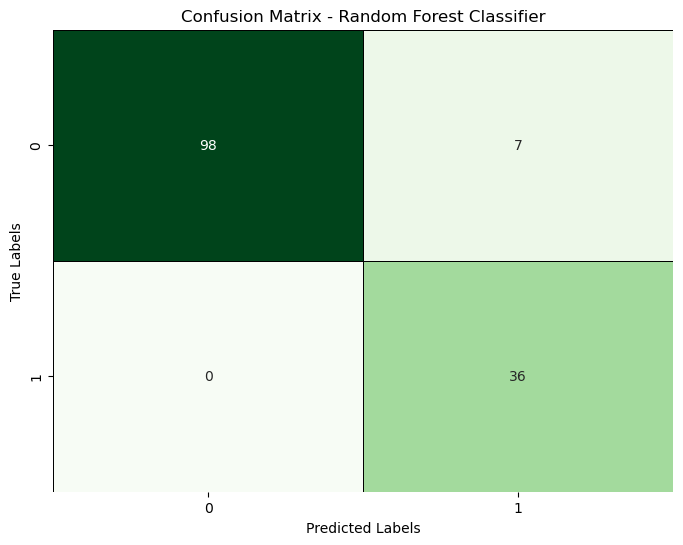

In [47]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rfc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Bigger figure for clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

AUC score (Random Forest): 0.9972


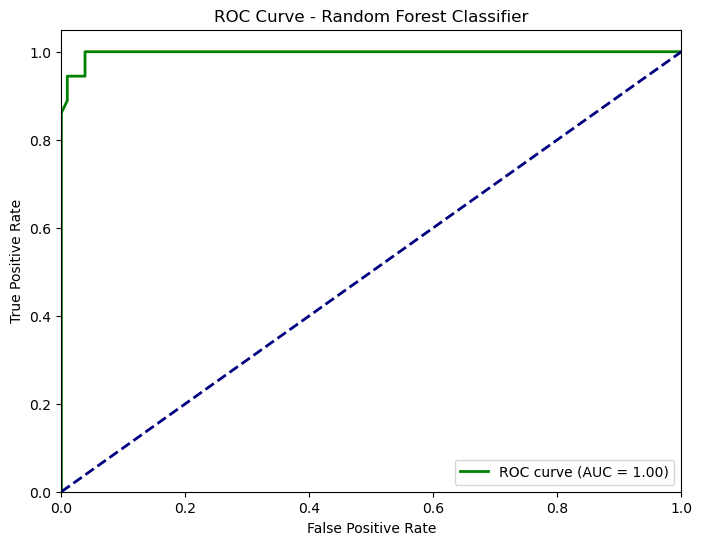

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (usually class 1)
y_pred_proba_rfc = model_rfc.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_proba_rfc)

# Compute AUC
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

print(f'AUC score (Random Forest): {auc_rfc:.4f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='green', lw=2, label=f'ROC curve (AUC = {auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal for random guess

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()


GaussianNB

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
model_params_gnb = {
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
           'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]

        }
    }
}

In [51]:
scores_gnb = []
CV_gnb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, mp in model_params_gnb.items():
    clf_gnb = GridSearchCV(
        mp['model'],
        mp['params'],
        cv=CV_gnb,
        scoring='accuracy',
        return_train_score=False
    )
    clf_gnb.fit(X_train_scaled, y_train)
    scores_gnb.append({
        'model': model_name,
        'best_score': clf_gnb.best_score_,
        'best_params': clf_gnb.best_params_
    })

In [52]:
df_gnb = pd.DataFrame(scores_gnb, columns=['model', 'best_score', 'best_params'])
pd.set_option('display.max_colwidth', None)
print(df_gnb)

        model  best_score               best_params
0  GaussianNB    0.895122  {'var_smoothing': 1e-09}


In [53]:
model_gnb = clf_gnb.best_estimator_
model_gnb.fit(X_train_scaled,y_train)

GaussianNB()

In [54]:
model_gnb.score(X_test_scaled,y_test)

0.9432624113475178

In [55]:
# Predictions and evaluation
y_pred_gnb = model_gnb.predict(X_test_scaled)

print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred_gnb))


Classification Report on Test Set:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       105
           1       0.82      1.00      0.90        36

    accuracy                           0.94       141
   macro avg       0.91      0.96      0.93       141
weighted avg       0.95      0.94      0.94       141



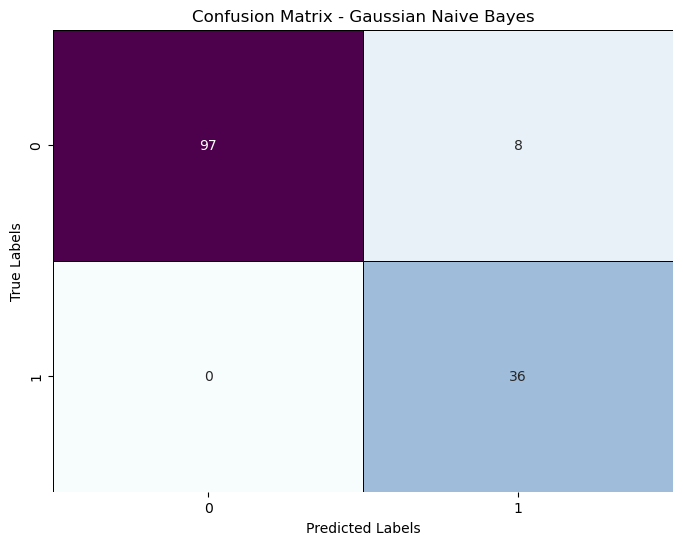

In [56]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_gnb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Make it larger for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', cbar=False,
            linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

AUC score (GaussianNB): 0.9966


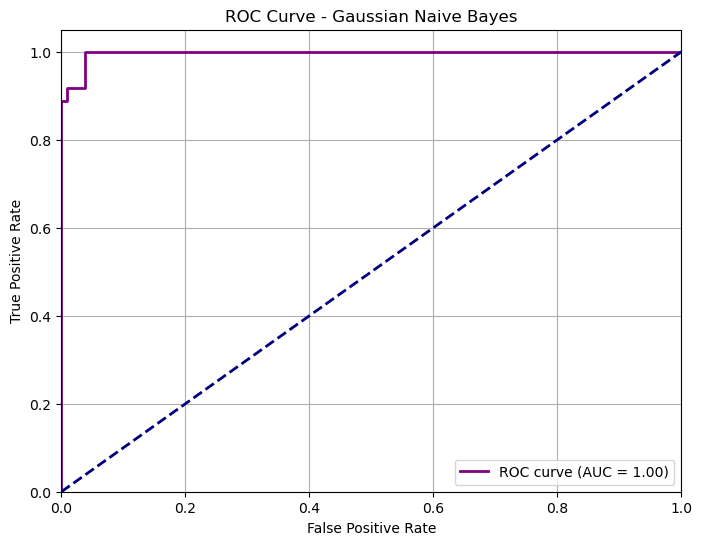

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_pred_proba_gnb = model_gnb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_proba_gnb)

# Compute AUC score
auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)

print(f"AUC score (GaussianNB): {auc_gnb:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='purple', lw=2, label=f'ROC curve (AUC = {auc_gnb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.grid()
plt.show()
